# `Setup`

In [ ]:
#!pip install -r /home/ucloud/upload/requirements.txt

In [4]:
!jupyter nbextension enable --py widgetsnbextension # Ucloud error workaround
!pip install ipywidgets --upgrade


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 139 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 48.1 MB/s eta 0:00:01


In [5]:
import os

#change path to /home/ucloud/
os.chdir('/home/ucloud/aml_itu')

# Printing current working directory
print("Current working directory: {0}".format(os.getcwd()))


Current working directory: /home/ucloud/aml_itu


In [1]:
import pandas as pd
import numpy as np
import os
from torchvision.transforms import Compose, Resize, Normalize, Lambda
import torchvision.transforms.functional as TF
from torch import float32
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import timm
from torchinfo import summary
import time 
import datetime as dt
import seaborn as sns
from contextlib import redirect_stdout
import io
import timm
import torch.nn as nn
import torch.optim as optim
import torch


# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

os.environ["COLAB"] = "False"

# check if cuda is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### `Config`

In [2]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config()

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '/home/ucloud/upload/driver_imgs_list.csv',
  'images': {'train': '/home/ucloud/upload/train_images_ucloud',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Main`

In [3]:
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.ColorJitter(),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize(224, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [4]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val+test'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

batch_size = 32
epochs = 50 
seed = 42

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Lenght of train data: 14409
Lenght of val data: 3345
Lenght of val data: 4670


In [5]:
label_map = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}

### (code from tinyVgg Training)

In [6]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')


class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False


def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)

def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)


def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

# importing model architecure & weights from timm

In [43]:
f = io.StringIO() # Ucloud error workaround
with redirect_stdout(f): # Ucloud error workaround
    model_name = 'efficientnet_b1'
    model = timm.create_model(model_name, pretrained=True)
    
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 10)
)


## gradual unfreezing

In [ ]:
# Function to unfreeze model layers
def unfreeze_model_layers(model, current_epoch, total_epochs):
    num_blocks = len(model.blocks)
    blocks_to_unfreeze = num_blocks * current_epoch // total_epochs

    # Freeze all layers initially
    if current_epoch == 0:
        for param in model.parameters():
            param.requires_grad = False

    # Gradually unfreeze the blocks
    for i in range(blocks_to_unfreeze):
        for param in model.blocks[-(i+1)].parameters():
            param.requires_grad = True

    # Unfreeze the final layers after all blocks are unfrozen
    if current_epoch >= total_epochs - 1:
        for param in model.conv_head.parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True


# training

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == targets).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / len(dataloader.dataset)
    return avg_loss, avg_accuracy

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == targets).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / len(dataloader.dataset)
    return avg_loss, avg_accuracy

# Initialize history
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# Initialize EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

# Training loop
epochs = 15
for epoch in range(epochs):

    # Unfreeze layers based on the current epoch
    unfreeze_model_layers(model, epoch, epochs)

    # Update optimizer for any newly unfrozen parameters
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-5)
    

    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    # Print epoch info
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model weights
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

    # Update history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # After the training loop
    visualize_training(history)

    # Update learning rate
    scheduler.step()

    # Check for early stopping
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered")
        break

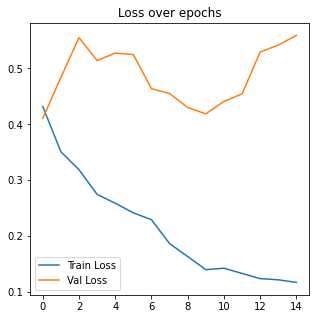

In [36]:
# Plotting the history
plt.figure(figsize=(5, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()